<a href="https://colab.research.google.com/github/ElBuberino/Tensorflow_Final_Project_Beatbox/blob/main/UNET_for_Audio_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ElBuberino/Tensorflow_Final_Project_Beatbox

Cloning into 'Tensorflow_Final_Project_Beatbox'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 386 (delta 28), reused 55 (delta 24), pack-reused 322
Receiving objects: 100% (386/386), 191.73 MiB | 17.10 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (314/314), done.


In [2]:
import pandas as pd
import os
import sys
from glob import glob
from IPython.display import Audio
from scipy.io import wavfile
import librosa
import librosa.display
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model 
from numpy import newaxis


# set path to the dataset
PATH = "/content/Tensorflow_Final_Project_Beatbox/Personal"
# set file ending
CSV = "*.csv"
WAV = "*.wav"
# initiate two empty lists to save the inputs and labels in
spec_list = []
label_list = []

# collect all csv files from the dataset
all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, CSV))]

# collect all wav files from the dataset
all_wav_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, WAV))]

# sort all files to assure that the right labels are assigned to the right inputs

all_csv_files = sorted(all_csv_files)
all_wav_files = sorted(all_wav_files)

In [3]:
# check the sorted csv list
for x in range(10):
  print(all_csv_files[x])

/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_1/P1_HHclosed_Personal.csv
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_1/P1_HHopened_Personal.csv
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_1/P1_Improvisation_Personal.csv
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_1/P1_Kick_Personal.csv
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_1/P1_Snare_Personal.csv
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_10/P10_HHclosed_Personal.csv
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_10/P10_HHopened_Personal.csv
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_10/P10_Improvisation_Personal.csv
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_10/P10_Kick_Personal.csv
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_10/P10_Snare_Personal.csv


In [4]:
# check the sorted wav list
for x in range(10):
  print(all_wav_files[x])

/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_1/P1_HHclosed_Personal.wav
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_1/P1_HHopened_Personal.wav
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_1/P1_Improvisation_Personal.wav
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_1/P1_Kick_Personal.wav
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_1/P1_Snare_Personal.wav
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_10/P10_HHclosed_Personal.wav
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_10/P10_HHopened_Personal.wav
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_10/P10_Improvisation_Personal.wav
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_10/P10_Kick_Personal.wav
/content/Tensorflow_Final_Project_Beatbox/Personal/Participant_10/P10_Snare_Personal.wav


In [5]:
for csv_file, wav_file in zip(all_csv_files, all_wav_files):

    ## Create inputs ##
    # Load the audio as a waveform y, store the sampling rate as sr
    y, sr = librosa.load(wav_file)
    # Create mel spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # append spectrograms to spec_list
    spectrogram = librosa.util.fix_length(data = spectrogram, size = 2048)
    
    # normalize values in spectrogram
    # find the minimum and maximum values of the spectrogram
    min_value = np.min(spectrogram)
    max_value = np.max(spectrogram)
    # normalize values to range [0,1]
    normalized_spectrogram = np.apply_along_axis(lambda x: (x - min_value) / (max_value - min_value), 1, spectrogram)
    # add a new axis for later network processing
    normalized_spectrogram = normalized_spectrogram[:, :, newaxis]
    # append spectrogram to spec_list
    spec_list.append(normalized_spectrogram)

    
    n_augmented = 0  
    # Data Augmentation
    for i in range(n_augmented):
      #noisy, sr = librosa.effects.add_noise(y,  SNR=20)     
      pitch_shift = librosa.effects.pitch_shift(y = y, sr = sr,n_steps=i*2)
      mel_spec = librosa.feature.melspectrogram(y=pitch_shift,sr=sr)
      fix_len = librosa.util.fix_length(data = mel_spec, size = 2048)
      min_value = np.min(fix_len)
      max_value = np.max(fix_len)
      # normalize values to range [0,1]
      normalized_spectrogram = np.apply_along_axis(lambda x: (x - min_value) / (max_value - min_value), 1, fix_len)
      normalized_spectrogram = np.expand_dims(normalized_spectrogram, axis = 2)
      spec_list.append(normalized_spectrogram)


    ## Create labels ##
    # read in csv file
    df = pd.read_csv(csv_file)
    # convert csv file to numpy array
    df_arr = df.to_numpy()
    # create array with onset datapoints
    df_onsets = df_arr[:, 0]
    # create array with sound categories
    df_vals = df_arr[:, 1]
    # create list with time indices of onset times
    time_indexes = []
    # store onset times in the shape of our spectrogram
    times = librosa.times_like(spectrogram)
    # append each onset time into times_indexes list
    for i in df_onsets:
        time_indexes.append(np.abs(times - i).argmin())

    # create blank target with the image-shape of our spectrogram
    target = np.zeros((1,2048,4))

    #print(df_vals, df_vals.shape)
    #print(time_indexes)

    # check the df_vals array for sound category for each onset

    for i, val in enumerate(time_indexes):
        if df_vals[i] == 'hhc':
            # put in channel 1 if the onset is a closes hi-hat
            target[:, val, 0] = 1.
        elif df_vals[i] == 'hho':
            #put in channel 2 if the onset is an open hi-hat
            target[:, val, 1] = 1.
        elif df_vals[i] == 'kd':
            # put in channel 3 if the onset is a kick drum
            target[:, val, 2] = 1.
        elif df_vals[i] == 'sd':
            # put in channel 4 if the onset is a snare drum
            target[:, val, 3] = 1.

    # np.set_printoptions(threshold=sys.maxsize)
    # print(target[0,0:3,0:4])

    # append targets to label_list
    label_list.append(target)
    for i in range(n_augmented):
      label_list.append(target)
      

In [6]:
# check lenght of input and label array
print(len(spec_list))
print(len(label_list))

140
140


In [7]:
# check one item for desired shape
print(spec_list[0].shape, label_list[0].shape)

(128, 2048, 1) (1, 2048, 4)


In [8]:
## Save lists as tf datasets ##
spec_ds = tf.data.Dataset.from_tensor_slices(spec_list)
label_ds = tf.data.Dataset.from_tensor_slices(label_list)

# zip together spec and label dataset
dataset = tf.data.Dataset.zip((spec_ds, label_ds))
# convert spectogram values to floats (normalization already performed)
dataset = dataset.map(lambda spec, target: (spec, tf.cast(target, tf.float32)))
# shuffle, batch, prefetch
dataset_pre = dataset.shuffle(1000)
dataset_pre = dataset_pre.batch(8)
dataset_pre = dataset_pre.prefetch(20)

print(dataset_pre)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 2048, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2048, 4), dtype=tf.float32, name=None))>


In [9]:
# check for desired shapes
for x,t in dataset_pre.take(1):
    print(x.shape, t.shape)

(8, 128, 2048, 1) (8, 1, 2048, 4)


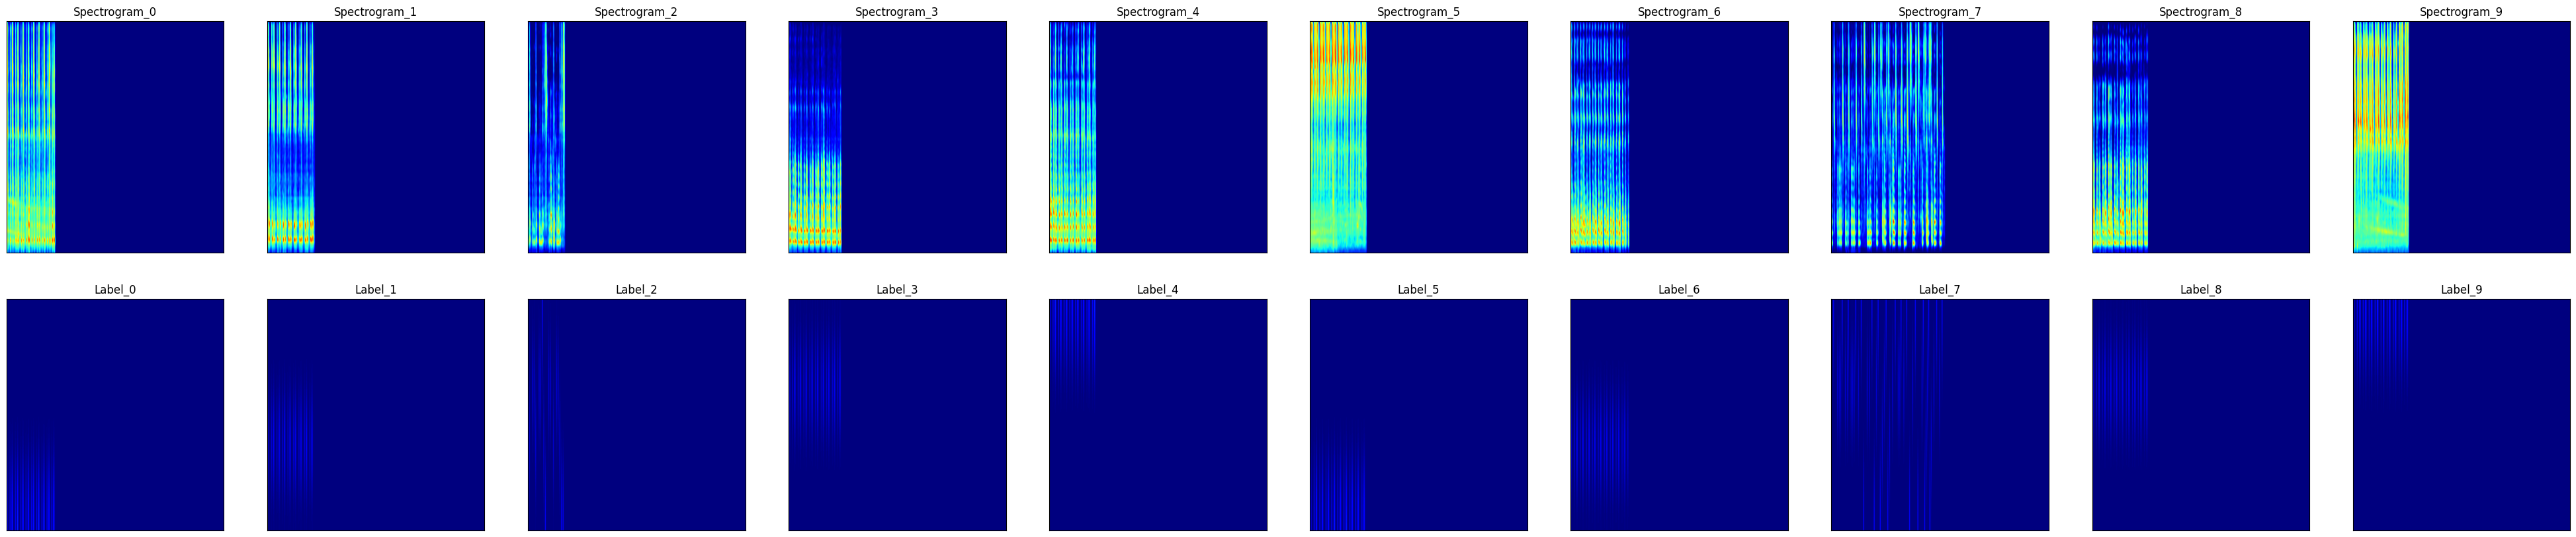

In [10]:
# Visualize the dataset with spectograms in the top row and the respective label in the bottom row
n = 10
fig, axs = plt.subplots(2, n, figsize=(50,10))

for idx, (input, target) in enumerate(dataset):
    if idx == n:
        break

    # display spectrogram
    ax = axs[0, idx]
    im = ax.imshow(librosa.power_to_db(input, ref=np.max), aspect='auto', origin='lower', interpolation='bicubic', cmap='jet')
    ax.set_title(f"Spectrogram_{idx}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display label
    ax = axs[1, idx]
    im = ax.imshow(tf.transpose(target), aspect='auto', origin='lower', interpolation='bicubic', cmap='jet')
    ax.set_title(f"Label_{idx}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [11]:
def conv_block(inputs, num_filters):
  # run two convolutions with same padding, kernel size 3, relu activation and batchnorm
  x = Conv2D(num_filters, 3, padding = 'same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

In [12]:
def encoder_block(inputs, num_filters):
  x = conv_block(inputs, num_filters)
  # MaxPooling(2,2) to reduce the size by half of the input array
  p = MaxPool2D((2,2))(x)

  return x, p

In [13]:
def decoder_block(inputs, skip_features, num_filters):
  # Up- convolution with strides = 2 in order to double the size of the input array and get the same size as the corresponding layer in the encoder
  x = Conv2DTranspose(num_filters, (2,2), strides = 2, padding = 'same')(inputs)
  # concatenate output with skip feature from the corresponding encoder layer of the same size
  x = Concatenate()([x, skip_features])
  # run classic convolution
  x = conv_block(x, num_filters)
  
  return x

In [14]:
def build_unet(input_shape):
  inputs = Input(input_shape)

  """Encoder"""

  # each encoder block returns one skip connection s (before pooling) and one pooling connection p for the contracting path
  s1, p1 = encoder_block(inputs, 8) # 8 filters
  s2, p2 = encoder_block(p1, 16) # 16 filters
  s3, p3 = encoder_block(p2, 32) #32 filters
  s4, p4 = encoder_block(p3, 64) # 64 filters

  """Bridge"""
  # conv block without further pooling
  b1 = conv_block(p4, 128)

  """Decoder"""

  # each decoder block receives the input from the previous layer and the skip connection s from its corresponding encoder layer
  d1 = decoder_block(b1, s4, 64) # 64 filters
  d2 = decoder_block(d1, s3, 32) # 32 filters
  d3 = decoder_block(d2, s2, 16) # 16 filters
  d4 = decoder_block(d3, s1, 8) # 8 filters

  """Output"""
  # Convolution with number of desired classes (4) as filters, kernelsize = 1 and softmax activation to normalize between [0,1]
  # Now we have 4 matrices (one for each sound class) with the same size of the original input spectrogram
  outputs = Conv2D(4, (1,1), padding = 'same', activation = 'softmax')(d4)

  # as we're only interested in the onset times a 1D - array suffices for each category
  # We reduce the vertical dimension with another conv layer of kernel size (128,1) to get four 1D arrays of the original lenght
  outputs = Conv2D(4, (128,1), padding = 'valid', activation = 'sigmoid')(outputs)

  model = Model(inputs, outputs, name = 'U-Net')
  return model

In [15]:
input_shape = (128,2048,1) 
input = dataset_pre
model = build_unet(input_shape)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
#model.summary()
history = model.fit(input, epochs = 10)

Epoch 1/10
18/18 [==============================] - 33s 321ms/step - loss: 0.0236 - acc: 0.6512
Epoch 2/10
18/18 [==============================] - 3s 171ms/step - loss: 0.0237 - acc: 0.3924
Epoch 3/10
18/18 [==============================] - 3s 171ms/step - loss: 0.0234 - acc: 0.3483
Epoch 4/10
18/18 [==============================] - 3s 172ms/step - loss: 0.0234 - acc: 0.1284
Epoch 5/10
18/18 [==============================] - 3s 173ms/step - loss: 0.0234 - acc: 0.0417
Epoch 6/10
18/18 [==============================] - 3s 173ms/step - loss: 0.0233 - acc: 0.0323
Epoch 7/10
18/18 [==============================] - 3s 174ms/step - loss: 0.0232 - acc: 0.0176
Epoch 8/10
18/18 [==============================] - 3s 176ms/step - loss: 0.0233 - acc: 0.0348
Epoch 9/10
18/18 [==============================] - 3s 176ms/step - loss: 0.0233 - acc: 0.0269
Epoch 10/10
18/18 [==============================] - 3s 178ms/step - loss: 0.0233 - acc: 0.0119


dict_keys(['loss', 'acc'])


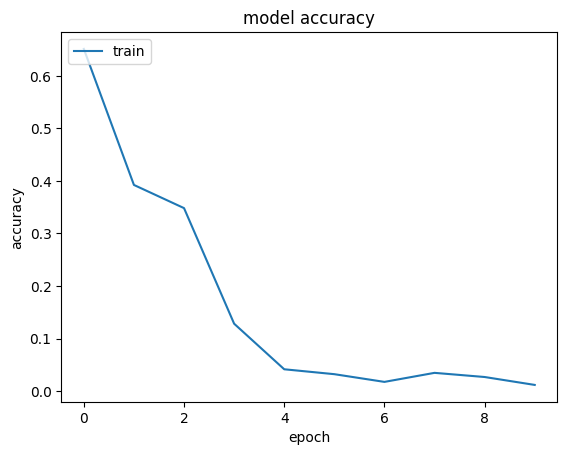

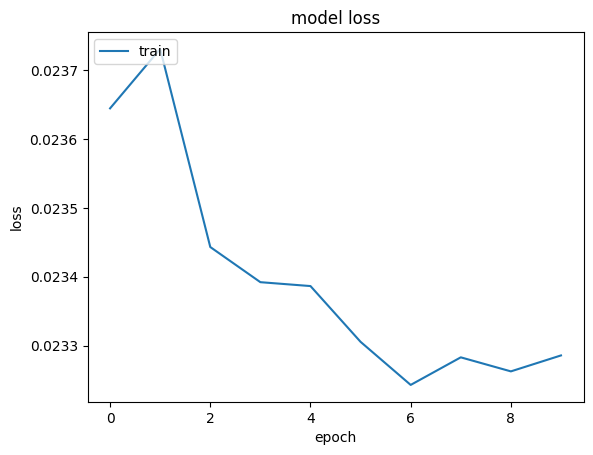

In [19]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()